# TP2 - Neural Networks with PyTorch

## Prerequisites

#### 1. What is PyTorch?

PyTorch is a system for executing dynamic computational graphs over Tensor objects that behave similarly as numpy ndarray. It comes with a powerful automatic differentiation engine that removes the need for manual back-propagation. 

#### 2. Why?

* Our code will now run on GPUs! Much faster training due to parallelisation of Tensors operations. When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly (which is beyond the scope of this class).
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry.

#### 2'. Useful links

* Pytorch documentation https://pytorch.org/docs/stable/index.html
* Basic Pytorch tutorial https://pytorch.org/tutorials/beginner/basics/intro.html


#### 3. GPU and Colab

You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

You need to manually switch to a GPU device. You can do this by clicking `Exécution -> Modifier le type d'exécution` and selecting `GPU` under `Accélérateur matèriel`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [ ]:
import torch

USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial
device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100
print('using device:', device)

using device: cpu


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better and prepare you for the final project. 

1. Part I. Preparation: we will use CIFAR-10 dataset.
2. Part II. Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors. 
3. Part III. PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define arbitrary neural network architecture. 
4. Part IV. PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a linear feed-forward network very conveniently. 
5. Part V. CIFAR-10 open-ended challenge: please implement your own network to get as high accuracy as possible on CIFAR-10. You can experiment with any layer, optimizer, hyperparameters or other advanced features. 

# Part I. Preparation

In this section, we will load and preprocess the data used. First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

The following code allows you first to visualize the data:

Files already downloaded and verified


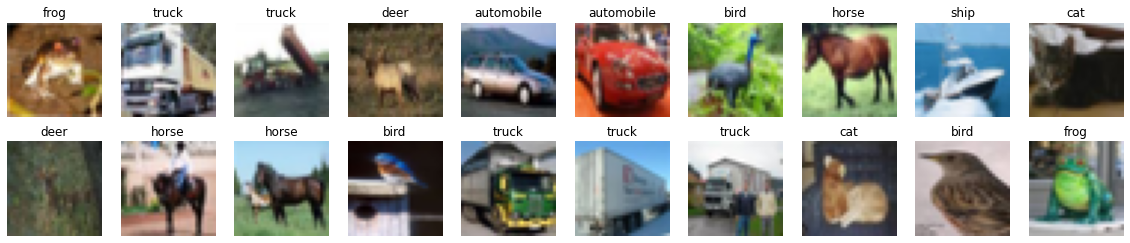

In [ ]:
# Some imports
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import pathlib
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
from torchvision.transforms.functional import rotate
import numpy as np

cifar10_train = dset.CIFAR10('datasets', train=True, download=True, transform=None)

fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for k in range(20):
    img, label = cifar10_train[k]
    class_name = cifar10_train.classes[label]
    ax[k//10][k%10].imshow(img)
    ax[k//10][k%10].set_title(class_name)
    ax[k//10][k%10].axis('off')

As in any machine learning problem, it is better to have the same order of magnitude for each coordinate of the input. In the case of natural images, the standard procedure is to standardize along the color channel dimensions.

**Q1.** Write the function `get_mu_std` which computes the mean and standard deviation on the full dataset. Check that your function gives `mu = [0.4914, 0.4822, 0.4465]` and `std = [0.2470, 0.2435, 0.2616]`. Directly use these values if you were not able to compute them.

*Hint 1: In order to avoid memory issues, the best practice is to compute running estimates of mean and std when parsing the dataset. Such an algorithm can be found here* https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance


*Hint 2: when iterating through the dataset with the code above, img objects are PIL images, you first need to convert them to numpy arrays with* `np.asarray` *to perform basic algebric operations.*

In [ ]:
def get_mu_std(dataset):
    ######################################
    # START code block: write code below
    ######################################
    images = np.asarray(dataset.data)/255
    mu = np.mean(images, axis=(0, 1, 2))
    std = np.std(images, axis=(0, 1, 2))
    ######################################
    # END code block
    ######################################
    return mu, std

mu, std = get_mu_std(cifar10_train)
print(f'Statistics per channel: mu={mu}, std={std}')

Statistics per channel: mu=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784]


The `torchvision.transforms` package provides tools for preprocessing data
and for performing data augmentation; here we set up a transform to:
1. convert PIL images into `torch.Tensor` (equivalent to the `np.array` in numpy)
2. preprocess the data by subtracting the mean RGB value and dividing by the standard deviation of each RGB value.

We set up a Dataset object for each split (train / val / test); Datasets load
training examples one at a time, so we wrap each Dataset in a DataLoader which
iterates through the Dataset and forms minibatches. We divide the CIFAR-10
training set into train and val sets by passing a Sampler object to the
DataLoader telling how it should sample from the underlying Dataset.

In [ ]:
NUM_TRAIN = 49000
transform = T.Compose([T.ToTensor(), T.Normalize(mu, std)])

cifar10_train = dset.CIFAR10('/datasets', train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('/datasets', train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('/datasets', train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Part II. Discovering PyTorch basics

In this section, we will manipulate basic PyTorch elements in a standard classification setting to understand the library better. We will start by building a simple fully-connected ReLU network (or Multi-Layer Perceptron, MLP) with two hidden layers. This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

*NB:* As a recall, the most convenient part of such library is the automatic differentiation machinery: that is we don't need to perform manual backpropagation. More specifically, when we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

## 1. Tensors and Flatten function

A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, the `flatten` function below reshapes image data given a consistent shape argument. Following PyTorch's convention, image data should be stored in a Tensor of shape N x C x H x W, where:

* N is the number of images
* C is the number of channels, e.g. 3 for RGB images
* H is the height of the images
* W is the weight of the images

This format is the only good format to represent the data when we are using classical PyTorch functions like a 2D convolution that needs spatial understanding of where the datapoints are relative to each other. When we use fully connected layers to process the image, however, we want each datapoint to be represented by a single vector. So, it is common to use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

*NB:* Note that this channel-first convention is typically different from other image libraries which often use the channel-last convention (H x W x C)

In [ ]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


Please read and understand the code above.

## 2. Two-Layer Perceptron

Similar to TP1, we will implement a 2-layer Perceptron for image classification. However, we here leverage the tools and automatic differentiation provided by the PyTorch framework.

**Q2.** Implement the function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. Check that it produces outputs of the right shape by running zeros through the network.

In [ ]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) representing a batch of data,
    - params: A list [w1, w2] of PyTorch Tensors giving the weights of the network.
    w1 has shape (d1 + ... + dM, H) and w2 has shape (H, C).

    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
    the input data x.
    """
    w1, w2 = params
    ######################################
    # START code block: write code below
    ######################################
    x = flatten(x)
    x = F.relu(x@w1)
    x = x
    res = x@w2
    ######################################
    # END code block
    ######################################
    return res

def test_two_layer_fc():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

test_two_layer_fc()

torch.Size([64, 10])


#### Important note

There is **no softmax activation** in the last layer of the network. Thus, it outputs real values, yet we have seen that the cross entropy loss - the standard loss for classification - expects inputs interpreted as probabilities (i.e. in [0,1] and sum to 1). This is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

## 3. Three-Layer CNN

In this section, you will implement a Convolutional Neural Networks (CNN) with three layers. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

**Q3.** Complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, you can test your implementation by passing zeros through the network. 

In [ ]:
def three_layer_cnn(x, params):
    """
    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    ######################################
    # START code block: write code below
    ######################################
    x = F.relu(torch.conv2d(x, conv_w1, conv_b1, padding=2))
    x = F.relu(torch.conv2d(x, conv_w2, conv_b2, padding=1))
    x = flatten(x)
    scores = x@fc_w+fc_b
    ######################################
    # END code block
    ######################################
    return scores

def test_three_layer_cnn():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_cnn(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]

test_three_layer_cnn()

torch.Size([64, 10])




*Hint*: use http://pytorch.org/docs/stable/nn.html#torch.nn.functional.conv2d and pay attention to the shapes of convolutional filters!

## 4. Weights initialization

As seen during the course, the initialization of the weights of the neural networks plays a key role for faster and better convergence. Let's write a couple utility methods to initialize the weight matrices for our models.

- `zero_weight` initializes a weight tensor with all zeros (e.g. for biais parameters) given a shape
- `random_weight` initialized a weight tensor with the Kaiming initialization method described in [1] given a shape

[1] He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [ ]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

Please read and understand the code above.

## 5. Compute accuracy

When training the model, we will need a function to compute the accuracy of our model on both training or validation sets. When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

**Q4.** Modify `compute_accuracy` function that outputs the classification score given a `loader`, a `model_fn` and associated `params`.

In [ ]:
def compute_accuracy(loader, model_fn, params):
    """
    Computes the accuracy of a classification model defined by `model_fn` and `params`
    on the data in `loader`
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.int64)

            ######################################
            # START code block: write code below
            ######################################
            pred = torch.argmax(model_fn(x, params), axis=1)
            num_correct += y.shape[0] - torch.count_nonzero(pred-y)
            num_samples += y.shape[0]
            ######################################
            # END code block
            ######################################

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
        
def test_compute_accuracy():
    """Dummy test of compute_accuracy"""
    hidden_layer_size = 50
    w1 = torch.zeros((3 * 32 * 32, hidden_layer_size)).to(device)
    w2 = torch.zeros((hidden_layer_size, 10)).to(device)
    loader = loader_train
    params = [w1, w2]
    acc = compute_accuracy(loader, two_layer_fc, params)

test_compute_accuracy()

Checking accuracy on the val set
Got 4913 / 49000 correct (10.03%)


By running the code above, the accuracy should be in the order of magnitude of 1 / 10 (number of classes).

*Remark:* the accuracy is classicaly defined as the ratio of the number of correct predictions (True Positive) among the total number of samples

## 6. Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](http://pytorch.org/docs/stable/nn.html#cross-entropy).

**Q5.** Modify the function `train` which takes as input the neural network function, a list of initialized parameters, and learning rate.

In [ ]:
def train(model_fn, params, learning_rate):
    """
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: the loss values at specific iterations
    """
    losses = {}
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.

        with torch.no_grad():
            ######################################
            # START code block: write code below
            ######################################            

            # Iterate over parameters and update them with SGD
            opt = optim.SGD(params, learning_rate)
            opt.step()

            ######################################
            # END code block
            ######################################
            
            # We manually zero the gradients after running the backward pass
            for p in params:
                p.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            losses[t] = loss.item()
            compute_accuracy(loader_val, model_fn, params)
            print()
    
    return losses

## 7. Train a Two-Layer Perceptron
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`.  After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

losses = train(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.0108
Checking accuracy on the val set
Got 128 / 1000 correct (12.80%)

Iteration 100, loss = 2.0727
Checking accuracy on the val set
Got 359 / 1000 correct (35.90%)

Iteration 200, loss = 1.8465
Checking accuracy on the val set
Got 389 / 1000 correct (38.90%)

Got 416 / 1000 correct (41.60%)

Iteration 400, loss = 1.9533
Checking accuracy on the val set
Got 397 / 1000 correct (39.70%)

Iteration 500, loss = 1.7990
Checking accuracy on the val set
Got 444 / 1000 correct (44.40%)

Iteration 600, loss = 1.8314
Checking accuracy on the val set
Got 464 / 1000 correct (46.40%)

Iteration 700, loss = 2.1275
Checking accuracy on the val set
Got 421 / 1000 correct (42.10%)




You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch. Run the cell below to check that the loss is decreasing w.r.t. the number of iterations

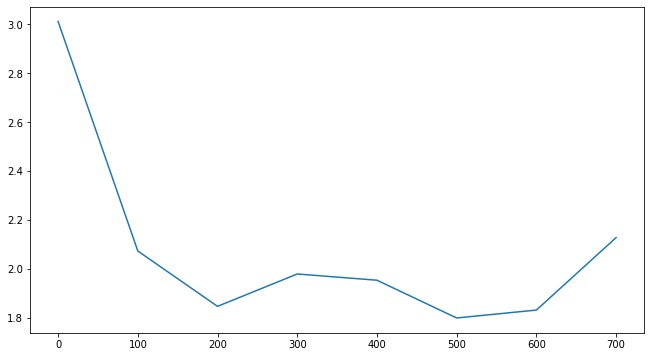

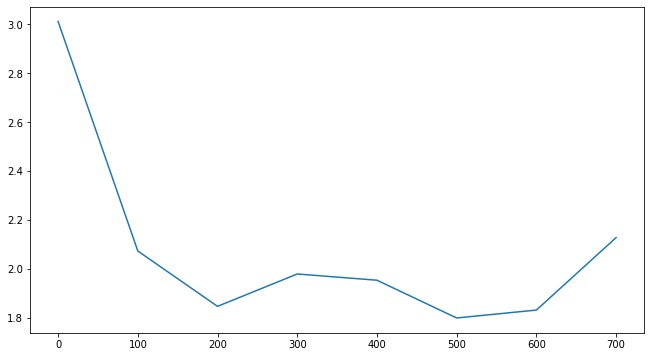

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(losses.keys())
y = [losses[e] for e in x]
ax.plot(x, y)
fig

### 8. Training a ConvNet

In the below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

**Q6.** Initialize your weight matrices using the `random_weight` function defined above, and initialize your bias vectors using the `zero_weight` function above and run the code below.

In [ ]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

######################################
# START code block: write code below
######################################            

conv_w1 = random_weight((channel_1, 3, 5, 5)).to(device)
conv_b1 = zero_weight((channel_1,)).to(device)
conv_w2 = random_weight((channel_2, channel_1, 3, 3)).to(device)
conv_b2 = zero_weight((channel_2,)).to(device)
fc_w = random_weight((channel_2*32*32, 10)).to(device)
fc_b = zero_weight((10,)).to(device)

######################################
# END code block
######################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
losses = train(three_layer_cnn, params, learning_rate)

Iteration 0, loss = 2.6031
Checking accuracy on the val set
Got 101 / 1000 correct (10.10%)

Iteration 100, loss = 1.9789
Checking accuracy on the val set
Got 319 / 1000 correct (31.90%)

Iteration 200, loss = 1.8002
Checking accuracy on the val set
Got 377 / 1000 correct (37.70%)

Iteration 300, loss = 1.6722
Checking accuracy on the val set
Got 399 / 1000 correct (39.90%)

Iteration 400, loss = 1.6035
Checking accuracy on the val set
Got 411 / 1000 correct (41.10%)

Iteration 500, loss = 1.5462
Checking accuracy on the val set
Got 437 / 1000 correct (43.70%)

Iteration 600, loss = 1.3857
Checking accuracy on the val set
Got 433 / 1000 correct (43.30%)

Iteration 700, loss = 1.4260
Checking accuracy on the val set
Got 470 / 1000 correct (47.00%)




You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 42% after one epoch. Run the cell below to check that the loss is decreasing w.r.t. the number of iterations

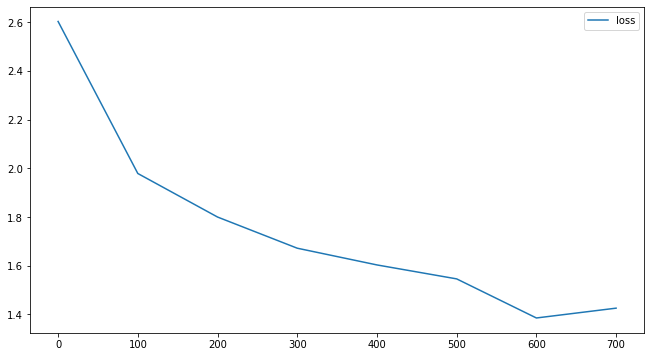

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(losses.keys())
y = [losses[e] for e in x]
ax.plot(x, y, label='loss')
ax.legend()
fig.show()

# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers and see their source code to understand how they are initialized. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 


After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### 1. Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [ ]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_TwoLayerFC()

torch.Size([64, 10])


You don't have to implement anything here, please read and understand the code above. If you have questions, you can ask on Slack.

### 2. Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes


**Q7.** Implement the three-layer ConvNet where the weight matrices of the model are initialized using the Kaiming normal initialization method. The `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [ ]:
from torch.nn.init import kaiming_normal_
from torch.nn.parameter import Parameter
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.conv_w1 = Parameter(torch.zeros((channel_1, in_channel, 5, 5)).to(device))
        kaiming_normal_(self.conv_w1)
        self.conv_w2 = Parameter(torch.zeros((channel_2, channel_1, 3, 3)).to(device))
        kaiming_normal_(self.conv_w2)
        self.fc_w = Parameter(torch.zeros((channel_2*32*32, num_classes)).to(device))
        kaiming_normal_(self.fc_w)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x = F.relu(torch.conv2d(x, self.conv_w1, padding=2))
        x = F.relu(torch.conv2d(x, self.conv_w2, padding=1))
        x = flatten(x)
        scores = x@self.fc_w

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype).to(device)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]

test_ThreeLayerConvNet()

torch.Size([64, 10])


*Hint*: You can find more information about convolutional modules at http://pytorch.org/docs/stable/nn.html#conv2d

### 3. Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

**Q8.** Implement the `check_accuracy` function that computes the score for a given `loader` and `model`. This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [ ]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            ######################################
            # START code block: write code below
            ######################################
            
            pred = torch.argmax(model(x), axis=1)
            num_correct += y.shape[0] - torch.count_nonzero(pred-y)
            num_samples += y.shape[0]

            ######################################
            # END code block
            ######################################

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f) ' % (num_correct, num_samples, 100 * acc))
        return acc

### 4. Validation loop

**Q9.** Implement a function `run_val` which takes as input `loader`, `model` and returns the loss computed on the full data of the loader.

In [ ]:
def run_val(loader, model):
    model.eval()
    loss = None
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            ######################################
            # START code block: write code below
            ######################################

            loss = F.cross_entropy(model(x), y)

            ######################################
            # END code block
            ######################################

    return loss

### 4. Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [ ]:
def train_module(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: the loss values at specific iterations
    """
    losses = {}
    losses_val = {}
    accuracy = {}
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Epoch %d, iteration %d, loss = %.4f' % (e, t, loss.item()))
                losses[e * len(loader_train) + t] = loss.item()
                accuracy[e * len(loader_train) + t] = check_accuracy(loader_val, model)
                
        
        loss_val = run_val(loader_val, model)
        losses_val[(e + 1) * len(loader_train)] = loss_val.item()

    return losses, losses_val, accuracy

You don't have to do anything in the code above, please read it carefully to understand it.

### 5. Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore. Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`.  You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

In [ ]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_train, loss_val, accuracy = train_module(model, optimizer)

Epoch 0, iteration 0, loss = 3.4105
Checking accuracy on validation set
Got 159 / 1000 correct (15.90) 
Epoch 0, iteration 100, loss = 1.9310
Checking accuracy on validation set
Got 333 / 1000 correct (33.30) 
Epoch 0, iteration 200, loss = 2.4166
Checking accuracy on validation set
Got 351 / 1000 correct (35.10) 
Epoch 0, iteration 300, loss = 1.7294
Checking accuracy on validation set
Got 427 / 1000 correct (42.70) 
Epoch 0, iteration 400, loss = 1.8417
Checking accuracy on validation set
Got 422 / 1000 correct (42.20) 
Epoch 0, iteration 500, loss = 1.5206
Checking accuracy on validation set
Got 430 / 1000 correct (43.00) 
Epoch 0, iteration 600, loss = 1.9805
Checking accuracy on validation set
Got 432 / 1000 correct (43.20) 
Epoch 0, iteration 700, loss = 1.5850
Checking accuracy on validation set
Got 471 / 1000 correct (47.10) 


KeyboardInterrupt: ignored


You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch. Run the cell below to check that the loss is decreasing w.r.t. the number of iterations

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(loss_train.keys())
y = [loss_train[e] for e in x]
ax.plot(x, y, label='loss_train')
ax.legend()
fig.show()

### 6. Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

**Q10.** Modify code below to instantiate and train a `ThreeLayerConvNet`. You should train the model using stochastic gradient descent without momentum. Alos, plot the train loss and the valid loss during training as well as the accuracy on the training and validation set.

In [ ]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = None
optimizer = None

################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

loss_train, loss_val, accuracy = train_module(model, optimizer, epochs=10)

You don't need to tune any hyperparameters, but you should see model accuracies above 45% after training for one epoch. Run the cell below to check that the loss is decreasing w.r.t. the number of iterations.

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(loss_train.keys())
y = [loss_train[e] for e in x]
ax.plot(x, y, label='loss_train')
x = sorted(loss_val.keys())
y = [loss_val[e] for e in x]
ax.plot(x, y, label='loss_val')
ax.legend()
fig.show()

# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### 1. Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [ ]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

_ = train_module(model, optimizer)

### 2. Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

**Q11.** Modify the code below to build a 3-layer ConvNet with the `nn.Sequential` API. You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above. You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

In [ ]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super(ThreeLayerConvNet, self).__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        self.sequence = nn.Sequential(
            nn.Conv2d(3, channel_1, 5, padding=2, bias=True).to(device),
            nn.ReLU(),
            nn.Conv2d(channel_1, channel_2, 3, padding=1, bias=True).to(device),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(channel_2 * 32 * 32, 10).to(device)
            )

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        for seq in self.sequence:
          x = seq(x)
        return x

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores

model = ThreeLayerConvNet(3, channel_1, channel_2, 10)
optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9, nesterov=True)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

losses, loss, accuracy = train_module(model, optimizer)

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training. Check that the loss is decreasing:

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(losses.keys())
y = [losses[e] for e in x]
ax.plot(x, y, label='loss')
x = sorted(accuracy.keys())
y = [accuracy[e] for e in x]
ax.plot(x, y, label='accuracy')
ax.legend()
fig.show()

# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [ ]:
class augmented_dataset(Dataset):

    def __init__(self, data):
        self.data = data
        self.transform = T.Compose([
            T.ToPILImage(),
            T.CenterCrop(torch.randint(1, 6, (1,)).item()),
            T.RandomRotation((-10, 10)),
            T.ToTensor()
        ])

    def __len__(self):
        return self.data.data.shape[0]

    def __getitem__(self, idx):
        item = self.data[idx]
        item = list(item)
        item[0] = self.transform(item[0])
        return item

augmented_dataset = augmented_dataset(cifar10_train)
augmented_dataset_train = ConcatDataset([cifar10_train, augmented_dataset])
loader_train = DataLoader(augmented_dataset_train, batch_size=100, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [ ]:
from torch.nn.modules.activation import LeakyReLU
resnet101 = models.resnet18(pretrained=True).to(device)
# for i,m in enumerate(resnet101.modules()):
#   if isinstance(m, nn.ReLU):
#     print(m)
#     m = nn.LeakyReLU(inplace=True)
resnet101.fc = nn.Linear(in_features=512, out_features=10, bias=True)
resnet101.relu = nn.LeakyReLU(inplace=True, )

In [ ]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
model = None
optimizer = None

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# optimizer = optim.SGD(resnet101.parameters(), 
#                       lr=0.1, 
#                       weight_decay=0, 
#                       momentum=0.9, 
#                       nesterov=True
#                       )
optimizer = optim.Adagrad(
    params = resnet101.parameters(),
    lr = 1e-2,
    weight_decay = 1e-4
)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
losses, loss, accuracy = train_module(resnet101, optimizer, epochs=10)

Epoch 0, iteration 0, loss = 2.5236
Checking accuracy on validation set
Got 112 / 1000 correct (11.20) 
Epoch 0, iteration 100, loss = 1.4618
Checking accuracy on validation set
Got 505 / 1000 correct (50.50) 
Epoch 0, iteration 200, loss = 1.4255
Checking accuracy on validation set
Got 623 / 1000 correct (62.30) 
Epoch 0, iteration 300, loss = 0.9993
Checking accuracy on validation set
Got 676 / 1000 correct (67.60) 
Epoch 0, iteration 400, loss = 0.9352
Checking accuracy on validation set
Got 737 / 1000 correct (73.70) 
Epoch 1, iteration 0, loss = 0.8312
Checking accuracy on validation set
Got 735 / 1000 correct (73.50) 
Epoch 1, iteration 100, loss = 0.5964
Checking accuracy on validation set
Got 748 / 1000 correct (74.80) 
Epoch 1, iteration 200, loss = 0.7004
Checking accuracy on validation set
Got 751 / 1000 correct (75.10) 
Epoch 1, iteration 300, loss = 0.6759
Checking accuracy on validation set
Got 783 / 1000 correct (78.30) 
Epoch 1, iteration 400, loss = 0.5226
Checking acc

In [ ]:
fig, ax = plt.subplots(figsize=(11, 6))
x = sorted(losses.keys())
y = [losses[e] for e in x]
ax.plot(x, y, label='loss')
x = sorted(accuracy.keys())
y = [accuracy[e] for e in x]
ax.plot(x, y, label='accuracy')
ax.legend()
ax.set_ylim(0,1.2)
fig.show()

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

TODO: Describe what you did

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [ ]:
best_model = resnet101
check_accuracy(loader_test, best_model)